In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import model_HIVandSTI
from tapm import utils
import icomo
import diffrax
import numpy as np

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
#output = integrator(y0=y0, constant_args=args)
output = icomo.diffeqsolve(
    args = model_HIVandSTI.args,
    ODE = model_HIVandSTI.main_model,
    y0 = model_HIVandSTI.y0,
    ts_out = np.linspace(0, 365*80, 365*80+1),
    max_steps=365*80+1)

INFO:tapm.HIVandSTI.model_HIVandSTI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.model_HIVandSTI:Parameters: m_min = 0.0, m_max = 1


A1 [1.70991964 1.55723521 0.58415172 0.40316683]
A2 [180.70968826 148.59565343  53.66115622  32.67956954]
A3 [9.95631632 8.19032061 2.95818864 1.80258843]
A4 [12.7418362  10.47724304  3.78352737  2.30408106]
D [2597.93200671 2059.19652954  732.87159102  423.90160297]
D_STI [2597.93200671 2059.19652954  732.87159102  423.90160297]
I1 [0.13700222 0.12473718 0.04679913 0.03234834]
I2 [22.67355323 18.81255569  6.81801606  4.20553839]
I3 [2.71559378 2.24914957 0.81455463 0.50117242]
I4 [2.69711784 2.22925403 0.8066875  0.49488492]
IP [0.06952934 0.063301   0.02374923 0.01641646]
Ia_STI [21205.26690583 15721.43163196  5314.21661071  3249.73458267]
Is_STI [270.5952832  200.64437583  67.85082727  41.54887639]
S [35338.28385936 27646.61652106  9788.0287535   5555.75269412]
SP [56540.37357711 44231.88749963 15659.60282498  8887.90593652]
S_STI [70009.59740042 55684.06134943 19977.8851784  11098.48883909]
T_STI [626.60840384 464.66611323 157.1757926   96.32609888]
HIV sum at start [Array(0.451, d

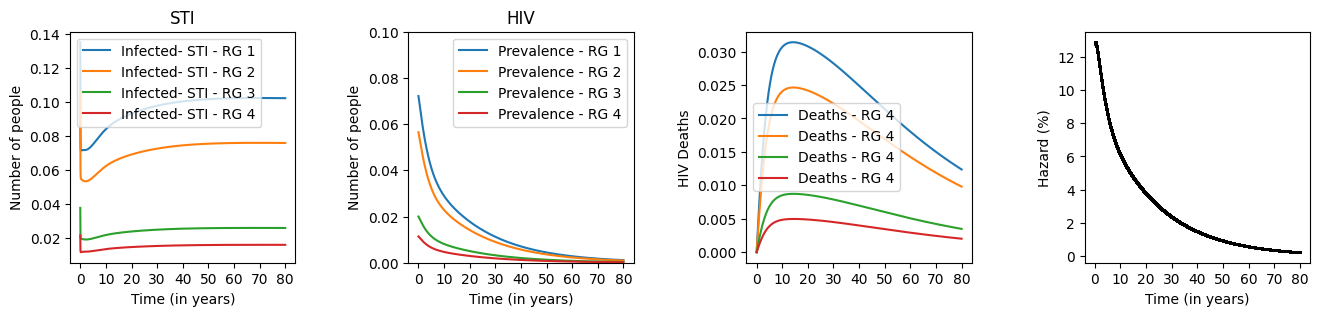

In [3]:

fig, axes = plt.subplots(1, 4, figsize=(16,3))
fig.subplots_adjust(wspace=0.5)

def number_of_people(comps, risk_group):
    total = 0
    for comp in comps:
        total += output.ys[comp][:,risk_group]
    return total

# STI
ax = axes[0]
for i in range(output.ys["Is_STI"].shape[1]):
    ax.plot(number_of_people(comps=("Is_STI", "Ia_STI"), risk_group=i), label="Infected- STI - RG "+str(i+1))

ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
#ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("STI")
ax.legend()

# HIV
ax = axes[1]
# ART per risk group
#for i in range(output.ys["A1"].shape[1]): # go through all risk groups
#    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4"), risk_group=i), label="ART - RG "+str(i+1)) # add all disease stages together

# I per risk group 
#for i in range(output.ys["I1"].shape[1]):
#    ax.plot(number_of_people(comps=("IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Infected - RG "+str(i+1))

# ART and I per risk group = Prevalence
for i in range(output.ys["I1"].shape[1]):
    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4", "IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Prevalence - RG "+str(i+1))


ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("HIV")
ax.legend()

# HIV deaths
ax = axes[2]
ax.plot(output.ys["D"], label="Deaths - RG "+str(i+1))
ax.legend()
ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylabel("HIV Deaths")

# hazard
ax = axes[3]
all_ART_keys = ["A1","A2","A3","A4"]
all_HIV_keys = ["S","SP","I1","I2","I3","I4","IP"] + all_ART_keys
all_STI_keys = ["S_STI","Ia_STI","Is_STI","T_STI"]
sum_vector = 0
compartment_matrix = 0
for i in range(output.ys["A1"].shape[1]):
    sum_vector += jnp.sum(jnp.array([output.ys[k][:,i] for k in all_HIV_keys]), axis=0)

for i in range(output.ys["A1"].shape[1]):
    compartment_matrix += jnp.sum(jnp.array([output.ys[key][:,i] for key in all_ART_keys]), axis=0)  # Shape: (len(all_ART_keys), time_points)
hazard_vector = compartment_matrix / sum_vector * 100   # Vectorized hazard computation

ax.scatter(range(len(hazard_vector)), hazard_vector, color="black", s=1)

ax.set_xticks(np.arange(0, 365*80+1, 365*10))
ax.set_xticklabels(np.arange(0, 81, 10))
ax.set_ylabel("Hazard (%)")
ax.set_xlabel("Time (in years)")

# print for each compartment in output the last time value
HIV_sum_at_end = [0,0,0,0]
STI_sum_at_end = [0,0,0,0]
HIV_sum_at_start = [0,0,0,0]
STI_sum_at_start = [0,0,0,0]

for key, value in output.ys.items():
    print(key, value[-1]*210000)

for key in (all_HIV_keys + ["D"]):
    for i in range(4):
        HIV_sum_at_end[i] += output.ys[key][-1,i]
        HIV_sum_at_start[i] += output.ys[key][0,i]
for key in (all_STI_keys + ["D_STI"]):
    for i in range(4):
        STI_sum_at_end[i] += output.ys[key][-1,i]
        STI_sum_at_start[i] += output.ys[key][0,i]
print("HIV sum at start", HIV_sum_at_start)
print("STI sum at start", STI_sum_at_start)
print("HIV sum at end", HIV_sum_at_end)
print("STI sum at end", STI_sum_at_end)